# $$
\begin{cases}
\Delta u =f \\
u \Big |_{\Gamma} = 0
\end{cases}
 \implies I(u) = \frac{1}{2}\iint_D\left[u_x^2 + u_y^2 \right]dxdy + \iint_Dfudxdy$$

# Replace the function $u$ with its interploation

# $$u(x,y) = \sum_{i, j}u_{ij}\varphi_{i, j}(x,y)$$

### $$ \frac{\partial}{\partial u_{kl}} \left\{\frac{1}{2} \iint_D\left[\left(\sum_{ij}u_{ij}\varphi_{x, ij}(x,y)\right)^2 + \left(\sum_{ij}u_{ij}\varphi_{y, ij}(x,y)\right)^2 \right]dxdy + 2\iint_D\sum_{ij}u_{ij}\varphi_{ij}(x,y)dxdy\right\} = 0$$

# $$\left(\sum_{ij}u_{ij}\varphi_{x, ij}(x,y)\right)^2 = u_{kl}^2\varphi_{x, kl}^2(x,y) + 2u_{kl}\varphi_{x, kl}(x,y)[\dots] + [\dots]^2$$

# $$\left(\sum_{ij}u_{ij}\varphi_{y, ij}(x,y)\right)^2 = u_{kl}^2\varphi_{y, kl}^2(x,y) + 2u_{kl}\varphi_{x, kl}(x,y)[\dots] + [\dots]^2$$

#### $$\frac{\partial}{\partial u_{kl}}I \left(\sum_{i, j}u_{ij}\varphi_{i, j}(x,y)\right)= \iint_D \left[2u_{kl}\varphi_{x, kl}^2(x,y) + 2u_{kl}\varphi_{x, kl}(x,y)[\dots] + 2u_{kl}\varphi_{y, kl}^2(x,y) + 2u_{kl}\varphi_{y, kl}(x,y)[\dots] + 2f_{kl}\varphi_{kl}(x,y)\right]dxdy$$

## $$\frac{\partial}{\partial u_{kl}}I \left(\sum_{i, j}u_{ij}\varphi_{i, j}(x,y)\right)= 8u_{k,l} - 2u_{k, l-1} - 2u_{k, l+1} - 2u_{k-1,l} - 2u_{k+1,l} = 0$$

In [1]:
import torch
import numpy
from tqdm import tqdm
import matplotlib.pyplot as plt
import sympy

# Example
# $$ D = \left[-\frac{\pi}{2},+\frac{\pi}{2}\right]\times\left[-\frac{\pi}{2},+\frac{\pi}{2}\right] $$
# $$
\begin{cases}
\Delta u = 2 \\
u \Big |_{\partial D} = 0
\end{cases}
$$

In [2]:
# x , y = sympy.symbols('x y')
# f =  0*x
# g = (x - sympy.pi)*(x + sympy.pi)*(y - sympy.pi)*(y + sympy.pi)
# f = f - (g.diff(x, x) + g.diff(y, y))
# f = sympy.lambdify((x, y), f)
# g = sympy.lambdify((x, y), g)

In [3]:
def f(x, y):
    return 2 * numpy.ones_like(x)

def g(x, y):
    return   numpy.zeros_like(x)

# Number of points per coordinate

In [4]:
n_points = 100

# Construct the necessary matrices

In [5]:
grid = numpy.linspace(-torch.pi/2, torch.pi/2, n_points)
grid_x, grid_y = numpy.meshgrid(grid, grid, indexing="ij")

In [6]:
grid_z = f(grid_x, grid_y)
h_1 = h_2 = grid[1] - grid[0]

In [7]:
b = - 2 * grid_z.reshape(-1)

In [8]:
matrix = numpy.zeros((n_points**2, n_points**2), dtype=numpy.float32)

for i in range(n_points**2):
    idx = numpy.unravel_index(i, (n_points, n_points))
    
    #These are Dirichlet boundary conditions 
    if True:
        if idx[0] == 0:
            matrix[i] *= 0
            matrix[i, i] = 1
            b[i] = 0
            continue
        if idx[0] == n_points - 1:
            matrix[i] *= 0
            matrix[i, i] = 1
            b[i] = 0
            continue
        if idx[1] == 0:
            matrix[i] *= 0
            matrix[i, i] = 1
            b[i] = 0
            continue       
        if idx[1] == n_points - 1:
            matrix[i] *= 0
            matrix[i, i] = 1
            b[i] = 0
            continue

    matrix[i, i] = 4 * (1/h_1**2 + 1/h_2**2)
    
    if i + 1 < n_points**2:
        matrix[i, i+1] = -2/h_1**2
            
    if i - 1 > 0:
        matrix[i, i-1] = -2/h_1**2
            
    if i + n_points + 1 < n_points**2:
        matrix[i, i+n_points] = -2/h_2**2
            
    if i - n_points > 0:
        matrix[i, i-n_points] = -2/h_2**2

In [9]:
u_simple = numpy.linalg.solve(matrix, b)
u_simple = u_simple.reshape(n_points, n_points)
u_simple += g(grid_x, grid_y)

In [10]:
# new_way
b = numpy.zeros(n_points**2)
matrix = numpy.zeros((n_points**2, n_points**2), dtype=numpy.float32)

for i in range(n_points**2):
    idx = numpy.unravel_index(i, (n_points, n_points))
    
    #These are Dirichlet boundary conditions 
    if True:
        if idx[0] == 0:
            matrix[i] *= 0
            matrix[i, i] = 1
            b[i] = 0
            continue
        if idx[0] == n_points - 1:
            matrix[i] *= 0
            matrix[i, i] = 1
            b[i] = 0
            continue
        if idx[1] == 0:
            matrix[i] *= 0
            matrix[i, i] = 1
            b[i] = 0
            continue       
        if idx[1] == n_points - 1:
            matrix[i] *= 0
            matrix[i, i] = 1
            b[i] = 0
            continue

    matrix[i, i] = 4 * (h_2/h_1 + h_1/h_2)
    
    if i + 1 < n_points**2:
        matrix[i, i+1] = -2*h_2/h_1
            
    if i - 1 > 0:
        matrix[i, i-1] = -2*h_2/h_1
            
    if i + n_points + 1 < n_points**2:
        matrix[i, i+n_points] = -2*h_1/h_2
            
    if i - n_points > 0:
        matrix[i, i-n_points] = -2*h_1/h_2
    
    
    edges = grid_z[idx[0]-1, idx[1]-1] + grid_z[idx[0]+1, idx[1]+1] +\
            grid_z[idx[0]-1, idx[1]+1] + grid_z[idx[0]+1, idx[1]-1]
    
    neigh = grid_z[idx[0]-1, idx[1]] + grid_z[idx[0]+1, idx[1]]+\
            grid_z[idx[0], idx[1]-1] + grid_z[idx[0], idx[1]+1]
    
    b[i] = -2 *(h_1*h_2)/36 * (edges + 4 * neigh + 16 * grid_z[idx])

# Solve the system of linear equations

In [11]:
u_simpson = numpy.linalg.solve(matrix, b)
u_simpson = u_simpson.reshape(n_points, n_points)

In [12]:
u_simpson += g(grid_x, grid_y)

# Basis function (pyramidal function)

In [11]:
def phi(X, Y, h1, h2, i, j, n_x, n_y):
    tx = numpy.linspace(X.min(), X.max(), n_x)
    ty = numpy.linspace(Y.min(), Y.max(), n_y)
    xx, yy = numpy.meshgrid(tx, ty, indexing="ij")
    xm = xx.min()
    ym = yy.min()
    xx = xx - ym
    yy = yy - ym
    tmp = numpy.zeros(xx.shape)
    S1 = (i <= xx/h1) & (xx/h1 <= i + 1) & (j <= yy/h2) & (yy/h2 <= j + 1) & (yy/h2 - j >= xx/h1 - i)
    tmp[S1] = (j + 1 - yy/h2)[S1]
    S2 = (i - 1 <= xx/h1) & (xx/h1 <= i) & (j <= yy/h2) & (yy/h2 <= j + 1) & (yy/h2 - j <= 1 + xx/h1 - i)
    tmp[S2] = (1 + xx/h1 - yy/h2 - i + j)[S2]
    S3 = (i - 1 <= xx/h1) & (xx/h1 <= i) & (j - 1 <= yy/h2) & (yy/h2 <= j) & (yy/h2 - j >= xx/h1 - i)
    tmp[S3] = (1 + xx/h1 - i)[S3]
    S4 = (i - 1 <= xx/h1) & (xx/h1 <= i) & (j - 1 <= yy/h2) & (yy/h2 <= j) & (yy/h2 - j <= xx/h1 - i)
    tmp[S4] = (1 + yy/h2 - j)[S4]
    S5 = (i <= xx/h1) & (xx/h1 <= i + 1) & (j - 1 <= yy/h2) & (yy/h2 <= j) & (yy/h2 - j >= xx/h1 - i - 1)
    tmp[S5] = (1 - xx/h1 + yy/h2 + i - j)[S5]
    S6 = (i <= xx/h1) & (xx/h1 <= i + 1) & (j <= yy/h2) & (yy/h2 <= j + 1) & (yy/h2 - j <= xx/h1 - i)
    tmp[S6] = (1 - xx/h1 + i)[S6]
    return tmp

# Sum up all the basis functions

In [13]:
t = torch.linspace(grid[0], grid[-1], 100)
xx, yy, = torch.meshgrid(t, t, indexing="ij")
z_simple = torch.zeros_like(xx)
z_simpson = torch.zeros_like(xx)


for i in range(n_points):
    for j in range(n_points):
        z_simple += phi(t, t, h_1, h_2, i, j, 100, 100)*u_simple[i][j]
        #z_simpson += phi(t, t, h_1, h_2, i, j, 100, 100)*u_simpson[i][j]

# Visualisation

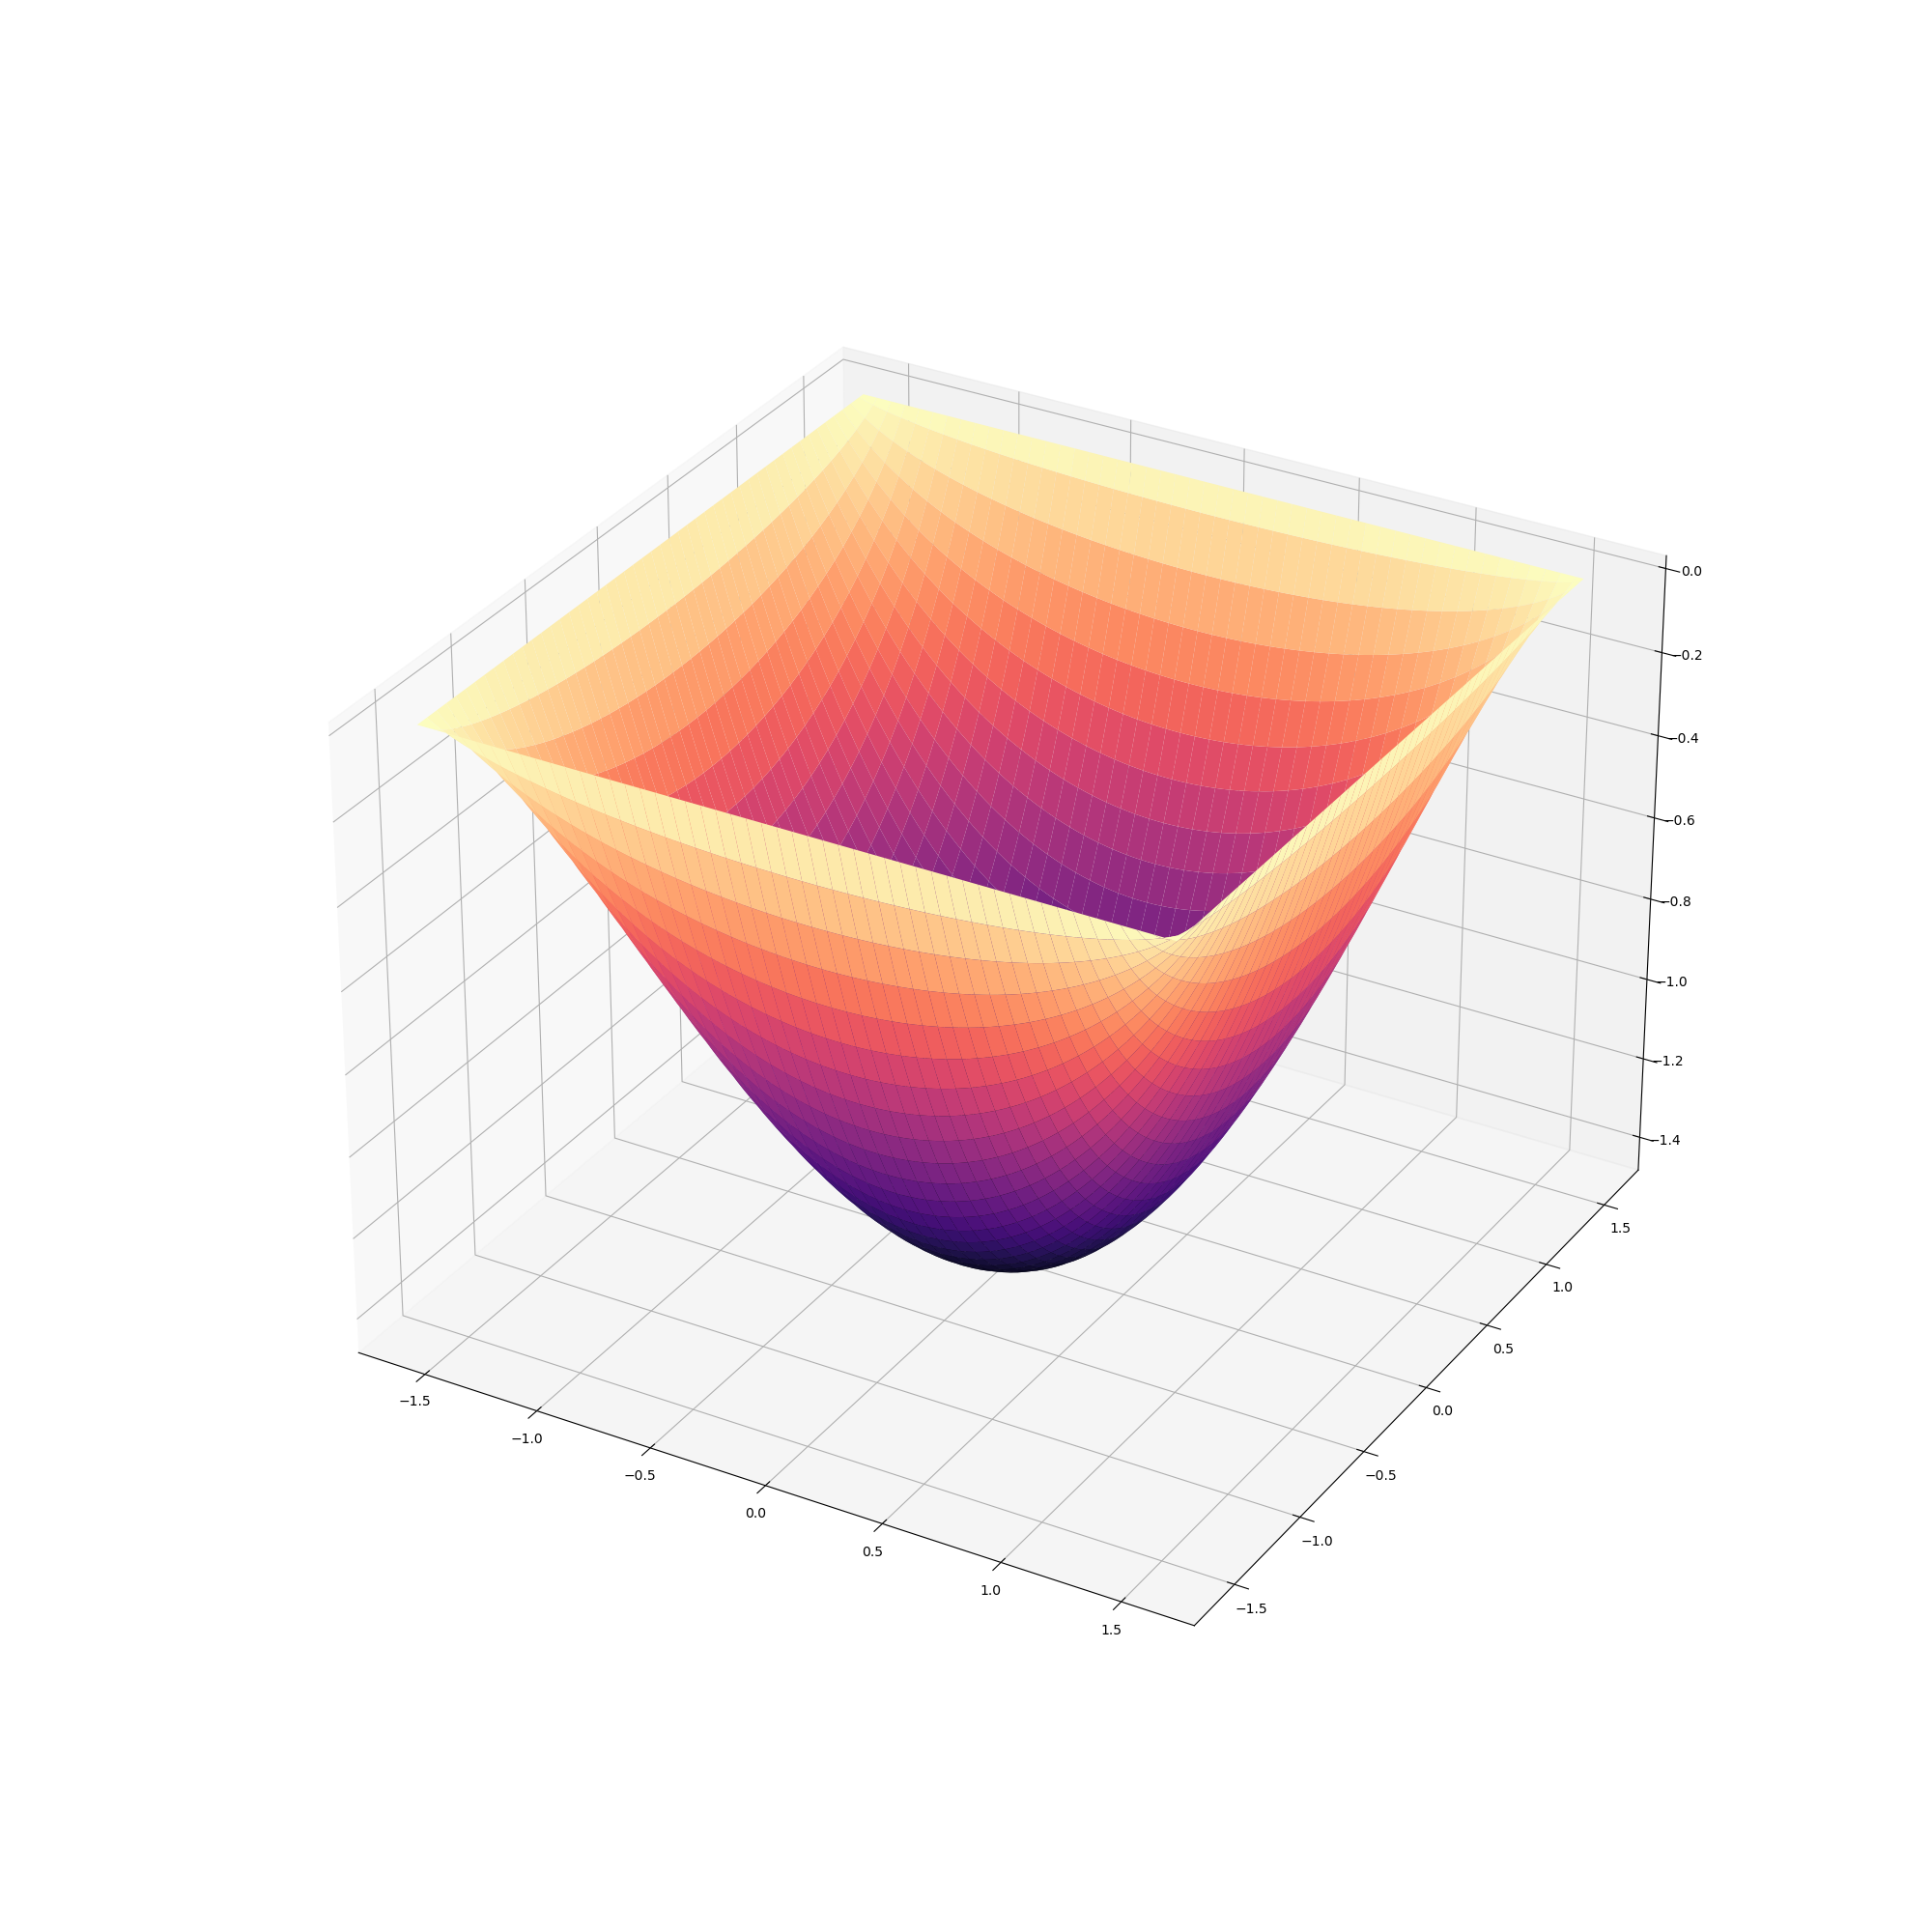

In [21]:
%matplotlib widget
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')
#ax.plot_wireframe(xx, yy, z_simple)
ax.plot_surface(xx, yy, z_simple, cmap="magma")
ax.set_aspect('auto')
plt.show()

In [16]:
z_original = torch.zeros_like(xx)

In [17]:
for k in range(1, 30):
    
    coef2 = (-1)**(k+1)/(2*k-1)**3
    ch1 = torch.cosh((2*k-1)*yy)
    ch2 = torch.cosh((2*k-1)*torch.tensor(torch.pi/2))
    cos = torch.cos((2*k-1)*xx)
    
    z_original += (coef2*ch1/ch2*cos)

In [18]:
z_original *= (8/torch.pi)

In [19]:
z_original += xx**2 - (torch.pi / 2)**2

In [20]:
error = (z_original-z_simple)
error[~torch.isnan(error)].abs().max().item()

0.3191489981291481

In [21]:
error = (z_original-z_simpson)
error[~torch.isnan(error)].abs().max().item()

0.3188925544877401